<h2>Wine Quality Prediction</h2>

Started: 12th of July, 2018

Finished: 12th of July, 2018

In this notebook I am going to build my very first regression/prediction machine learning project with no external sources or help. Hopefully it will succeed. I will try to find a simple and interesting dataset from <a href="https://www.kaggle.com/datasets">www.kaggle.com</a> or some other website. Note: regression may not be the best solution, seems more like a classification problem, but the dataset seems good for both categories and I would like to practice regression.



In [149]:
#some things I will need
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import pickle

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint, reciprocal, expon

from pandas.plotting import scatter_matrix

%matplotlib inline

<h1>Getting the Data</h1>

In [8]:
import os
from six.moves import urllib

LINK = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/"
WINE_PATH = "datasets/wines"
files = ["winequality-red.csv", "winequality-white.csv", "winequality.names"]

def fetch_data(url=LINK, wine=WINE_PATH):
    if not os.path.isdir(wine):
        os.makedirs(wine)
    for download in files:
        download_path = url + download
        file_path = os.path.join(wine, download)
        urllib.request.urlretrieve(download_path, file_path)
        
fetch_data()

In [19]:
def load_data(load_path = WINE_PATH):
    csv_red_wine = os.path.join(load_path, files[0])
    csv_white_wine = os.path.join(load_path, files[1])
    return pd.read_csv(csv_red_wine), pd.read_csv(csv_white_wine)

red_wine, white_wine = load_data()

# Splitting the Training and Testing Datasets

This is highly recommended to avoid over- or underfitting. I will split them using a stratifying method.

In [33]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(red_wine, red_wine["quality"]):
    r_train = red_wine.loc[train_idx]
    r_test = red_wine.loc[test_idx]

print(red_wine["quality"].value_counts() / len(red_wine))
print(r_train["quality"].value_counts() / len(r_train))

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64
5    0.426114
6    0.398749
7    0.124316
4    0.032838
8    0.011728
3    0.006255
Name: quality, dtype: float64


With this I've succesfully avoided to have a biased predictor... I will do the same for white wines.

In [34]:
for train_idx, test_idx in split.split(white_wine, white_wine["quality"]):
    w_train = white_wine.loc[train_idx]
    W_test = white_wine.loc[test_idx]

print(white_wine["quality"].value_counts() / len(white_wine))
print(w_train["quality"].value_counts() / len(w_train))

6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64
6    0.448698
5    0.297601
7    0.179684
8    0.035733
4    0.033180
3    0.004084
9    0.001021
Name: quality, dtype: float64


# Getting to know the Data

I would like to know better the data before starting anything else. I'll just use some simple tools provided by pandas to explore the attributes and features. Since I have two types of wine I am going to visualize, train, and make predictions with them separately. The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. 

In [35]:
r_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1542,6.7,0.855,0.02,1.9,0.064,29.0,38.0,0.99472,3.30,0.56,10.75,6
1558,6.9,0.630,0.33,6.7,0.235,66.0,115.0,0.99787,3.22,0.56,9.50,5
344,11.9,0.570,0.50,2.6,0.082,6.0,32.0,1.00060,3.12,0.78,10.70,6
924,8.6,0.470,0.27,2.3,0.055,14.0,28.0,0.99516,3.18,0.80,11.20,5
971,10.4,0.260,0.48,1.9,0.066,6.0,10.0,0.99724,3.33,0.87,10.90,6


The dataset seems clear and okay at first sight. I have only numerical data, so I won't need to labelize any attribute.

In [36]:
r_train.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 1542 to 1083
Data columns (total 12 columns):
fixed acidity           1279 non-null float64
volatile acidity        1279 non-null float64
citric acid             1279 non-null float64
residual sugar          1279 non-null float64
chlorides               1279 non-null float64
free sulfur dioxide     1279 non-null float64
total sulfur dioxide    1279 non-null float64
density                 1279 non-null float64
pH                      1279 non-null float64
sulphates               1279 non-null float64
alcohol                 1279 non-null float64
quality                 1279 non-null int64
dtypes: float64(11), int64(1)
memory usage: 129.9 KB


In [37]:
r_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.306489,0.528073,0.273878,2.543589,0.088934,16.127834,47.280688,0.996735,3.308585,0.663675,10.424446,5.637217
std,1.695325,0.177710,0.194902,1.375697,0.050981,10.473562,33.334786,0.001852,0.151599,0.178360,1.065672,0.808633
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000,3.000000
25%,7.100000,0.395000,0.100000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.080000,14.000000,39.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.300000,0.635000,0.430000,2.600000,0.091000,22.000000,64.000000,0.997800,3.400000,0.740000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.400000,0.611000,68.000000,289.000000,1.003690,3.900000,2.000000,14.900000,8.000000


Most of the red wines got an average quality of 5 or 6, I think it will be neccessary to use an algorithm for outliers.

In [38]:
w_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000
mean,6.860324,0.277491,0.334104,6.423175,0.045738,35.455207,138.384380,0.994053,3.188839,0.489096,10.506281,5.877999
std,0.853426,0.099712,0.121029,5.103707,0.021377,17.118267,42.451829,0.003008,0.152845,0.113876,1.224799,0.885547
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,24.000000,109.000000,0.991760,3.080000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993780,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.975000,0.050000,46.000000,167.000000,0.996158,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


There are even more outliers in the white wine category. I will try to use random forest regression with an outlier algorithm, that should do the job.

# Visualizing the Data

I am not going to analyze separately red and white wines, they seem to be really similar. Of course the regression/classification will happen separately.

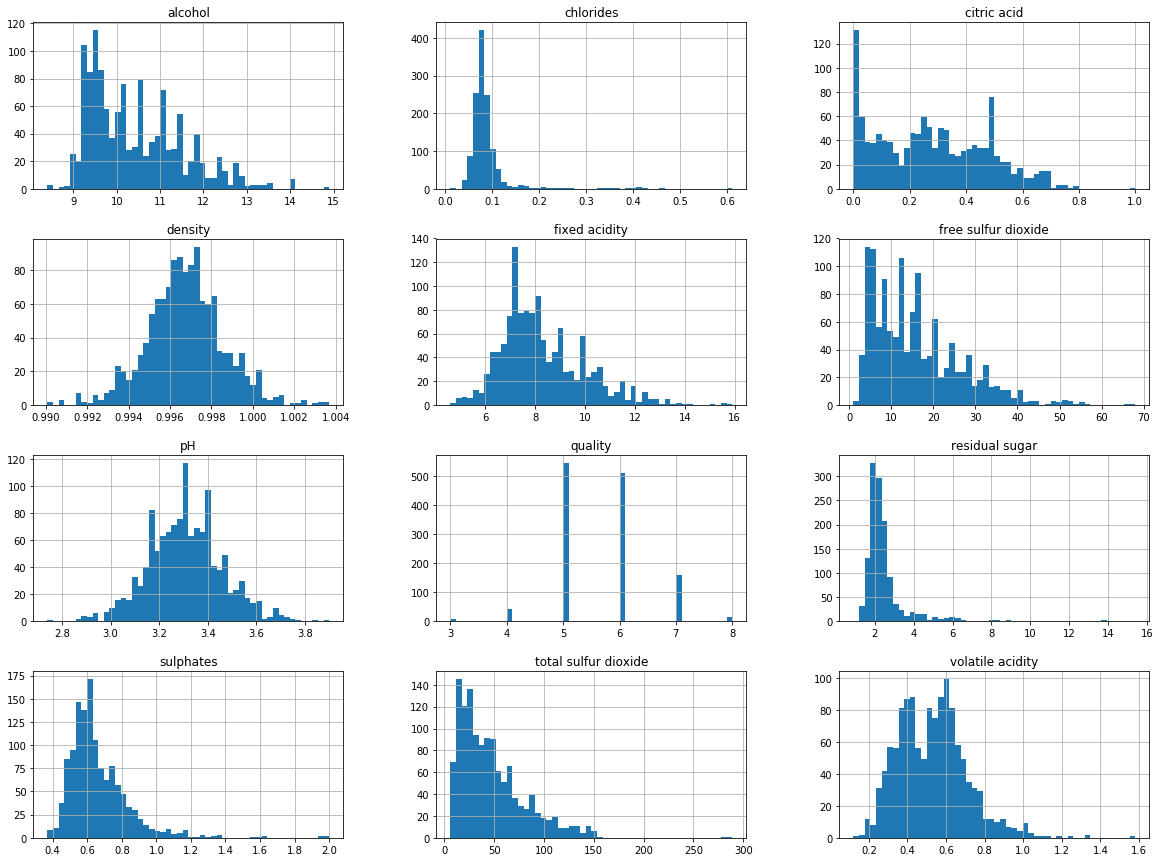

In [39]:
r_train.hist(bins = 50, figsize=(20, 15))
plt.show()

There are too many attributes to find correlations simply by plotting them. I will use a correlations matrix to find out what makes a great white / red wine.

In [47]:
w_correlations = w_train.corr()

In [48]:
w_correlations["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.436667
pH                      0.106258
sulphates               0.054350
free sulfur dioxide     0.010098
citric acid            -0.003164
residual sugar         -0.093205
fixed acidity          -0.113035
total sulfur dioxide   -0.171857
volatile acidity       -0.205380
chlorides              -0.212627
density                -0.301902
Name: quality, dtype: float64

Seems like alcohol percantage, pH value, and sulphates have a big role in the wine quality. Good to know that, let's make a visualisation about the correlations matrix.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000183BEF40F98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000183BE008668>]], dtype=object)

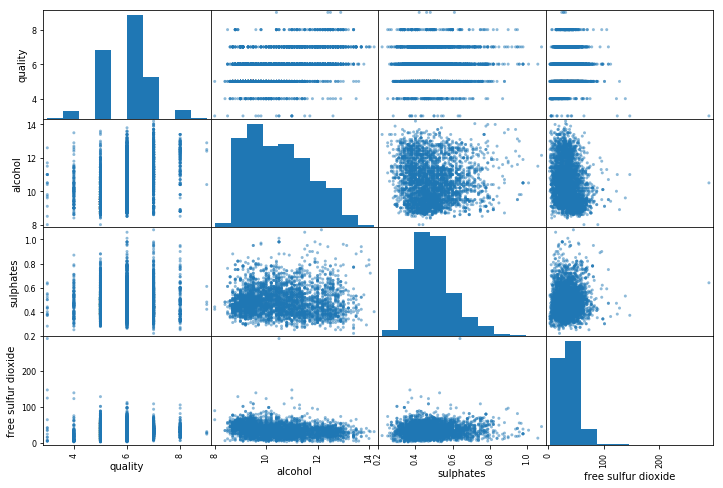

In [54]:
attributes = ["quality", "alcohol", "sulphates", "free sulfur dioxide"]
scatter_matrix(w_train[attributes], figsize=(12, 8))

Amazing, now correlations are relatively clear to me.

# Preparing the Data for Machine Learning

This dataset seems well organized and clear I won't change much, but I am going to use a function or pipeline for preprocessing so it will be easier to work with two datasets.

In [55]:
w_attrs = w_train.drop("quality", axis=1)
w_labels = w_train["quality"]

r_attrs = r_train.drop("quality", axis=1)
r_labels = r_train["quality"]

In [63]:
sc = StandardScaler()
w_attrs = sc.fit_transform(w_attrs)
r_attrs = sc.fit_transform(r_attrs)

# Functions for Predictions

In [151]:
def random_forest(data, labels):
    forest_reg = RandomForestRegressor()
    param_distrib = {
        'n_estimators': randint(low = 3, high=180),
        'bootstrap': [False, True],
        'max_features': randint(low = 2, high=10),
    } 
    
    rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distrib, n_iter = 10, cv=5, 
                                    scoring="neg_mean_squared_error", random_state=42)
    return rnd_search.fit(data, labels)


def support_vector(data, labels):
    sv_reg = SVR()
    param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }
    
    sv_search = RandomizedSearchCV(sv_reg, param_distributions=param_distribs, n_iter = 10, cv=5, 
                                    scoring="neg_mean_squared_error", random_state=42)
    return sv_search.fit(data, labels)


def decision_tree(data, labels):
    tree_reg = DecisionTreeRegressor()
    param_distribs = {
        'max_features': randint(low=1, high=10),
        'splitter': ["best", "random"],
        'min_samples_split': randint(low=2, high=6),
    }
    
    tree_search = RandomizedSearchCV(tree_reg, param_distributions=param_distribs, n_iter = 10, cv=5, 
                                    scoring="neg_mean_squared_error", random_state=42)
    return tree_search.fit(data, labels)

def test_measurement(prediction, labels):
    #error measurement
    rounded_test = np.round(prediction)

    correct = 0
    for idx in range(len(rounded_test)):
        if rounded_test[idx] == labels.iloc[idx]:
            correct+=1

    print("Succes rate: ", correct/len(prediction) * 100,"%")

# Random Forest Regressor

In [73]:
forest_model = random_forest(w_attrs, w_labels)
forest_model = forest_model.best_estimator_

In [91]:
prediction = forest_model.fit(w_attrs, w_labels).predict(w_attrs)
print("Prediction: ", prediction[:5])
print("Real Values:", w_labels[:5])

Prediction:  [ 7.  7.  5.  6.  8.]
Real_Values: 3690    7
3463    7
683     5
3698    6
3253    8
Name: quality, dtype: int64


In [90]:
prediction = forest_model.fit(r_attrs, r_labels).predict(r_attrs)
print("Prediction: ", prediction[:5])
print("Real Values:", r_labels[:5])

Prediction:  [ 6.  5.  6.  5.  6.]
Real_Values: 1542    6
1558    5
344     6
924     5
971     6
Name: quality, dtype: int64


In [100]:
#testing
w_test_set = W_test.drop("quality", axis=1)
w_test_labels = W_test["quality"]

w_test_set = sc.fit_transform(w_test_set)
test_pred = forest_model.predict(w_test_set)

tested_mse = mean_squared_error(w_test_labels, test_pred)
tested_rmse = np.sqrt(tested_mse)
tested_rmse

0.61299926692511364

In [133]:
test_measurement(test_pred, w_test_labels)

Succes rate:  67.55102040816327 %


Not that bad, but I would like to try other methods. The model is probably is probably overfitted, but I don't have patience to fix this right now...

# Decision Tree Regressor

In [127]:
tree_model = decision_tree(w_attrs, w_labels)
print(tree_model.best_estimator_)
tree_model = tree_model.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=7,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


In [154]:
tree_model.fit(w_attrs, w_labels).predict(w_attrs)
prediction = tree_model.fit(w_attrs, w_labels).predict(w_attrs)

test_measurement(prediction, w_labels)

Succes rate:  94.10413476263399 %


In [155]:
final_prediction = tree_model.predict(w_test_set)
test_measurement(final_prediction, w_test_labels)

Succes rate:  52.244897959183675 %


In [156]:
print("Prediction: ", final_prediction[10:15])
print("Real Values:", w_test_labels[10:15])

Prediction:  [ 7.   6.5  6.   7.   6. ]
Real Values: 3243    7
730     6
4702    6
1200    6
4326    5
Name: quality, dtype: int64


In [158]:
tested_mse = mean_squared_error(w_test_labels, final_prediction)
tested_rmse = np.sqrt(tested_mse)
tested_rmse

0.85701884023456965

This was a lot worse, but I only got a bad percentage because I wa trying to calculate efficiency with a tipical classification error calculation method. The regression algorithms did their job pretty well, the RMSE error calculation gave me a standard deviation of less than 1 that is still acceptable as a firts try.

# Support Vector Machine Regressor

In [152]:
sv_model = support_vector(w_attrs, w_labels)
print(sv_model.best_estimator_)
sv_model = sv_model.best_estimator_

SVR(C=26290.206464300216, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.90844696963212535, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)


In [161]:
prediction = sv_model.fit(w_attrs, w_labels).predict(w_attrs)
tested_mse = mean_squared_error(w_labels, prediction)
tested_rmse = np.sqrt(tested_mse)
tested_rmse

0.096332288564743976

In [163]:
test_measurement(prediction, w_labels)

Succes rate:  100.0 %


This looks really promising, the training took almost two hours, so this should work properly.

In [165]:
final_prediction = sv_model.predict(w_test_set)
tested_mse = mean_squared_error(w_test_labels, final_prediction)
tested_rmse = np.sqrt(tested_mse)
tested_rmse

0.6590383756350201

In [166]:
test_measurement(final_prediction, w_test_labels)

Succes rate:  65.0 %


Still somewhat better than the decision tree regressor.

# Conclusion

My goal was to practice regression algorithms and do a machine learning exercise on my own. I did that sucessfully. I would probably get a better result with more preprocessing and better configurations, but this is fine for now.
<h1> Note that the real prediction accuracy is around 85% by measuring RMSE and standard deviation, the 67% or 65% succes rate shows how much rounded values got predicted correctly.</h1>